In [1]:

import os, json, pickle, random
from collections import defaultdict, Counter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

DATA_DIR    = "./data"
CORPUS_FILE = os.path.join(DATA_DIR, "corpus.txt")
TEST_FILE   = os.path.join(DATA_DIR, "test.txt")
OUT_DIR     = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

ALPHABET = [chr(ord('A')+i) for i in range(26)]
CHAR2ID  = {c:i for i,c in enumerate(ALPHABET)}
ID2CHAR  = {i:c for c,i in CHAR2ID.items()}


In [2]:

def load_words(path):
    with open(path, "r", encoding="utf-8") as f:
        words = [w.strip().upper() for w in f if w.strip()]
    # keep only A-Z
    return [w for w in words if all('A' <= c <= 'Z' for c in w)]

def normalize_rows(mat, eps=1e-12):
    s = mat.sum(axis=1, keepdims=True)
    s[s < eps] = 1.0
    return mat / s

def normalize_vec(v, eps=1e-12):
    s = v.sum()
    if s < eps: return np.ones_like(v)/len(v)
    return v / s

def moving_average(x, k=200):
    if len(x) < k: return x
    kernel = np.ones(k)/k
    return np.convolve(x, kernel, mode="valid")

In [3]:

class TrueHMM:
    def __init__(self, num_states=8, seed=0, smoothing=1e-3):
        rng = np.random.default_rng(seed)
        self.K = num_states
        self.M = len(ALPHABET)
        self.pi = normalize_vec(rng.random(self.K))
        self.A  = normalize_rows(rng.random((self.K, self.K)))
        self.B  = normalize_rows(rng.random((self.K, self.M)))
        self.smoothing = smoothing
        self.global_letter_freq = np.ones(self.M) / self.M

    def _forward(self, emissions, E):
        T = len(emissions)
        alpha = np.zeros((T, self.K))
        scale = np.zeros(T)

        emit0 = self.B[:, emissions[0]] if E is None else E[0]
        alpha[0] = self.pi * emit0
        scale[0] = alpha[0].sum()
        if scale[0] == 0:
            alpha[0] = normalize_vec(alpha[0]); scale[0] = 1.0
        else:
            alpha[0] /= scale[0]

        for t in range(1, T):
            emit = self.B[:, emissions[t]] if E is None else E[t]
            alpha[t] = (alpha[t-1] @ self.A) * emit
            s = alpha[t].sum()
            if s == 0:
                alpha[t] = normalize_vec(alpha[t]); s = 1.0
            else:
                alpha[t] /= s
            scale[t] = s
        return alpha, scale

    def _backward(self, emissions, scale, E):
        T = len(emissions)
        beta = np.zeros((T, self.K))
        beta[-1] = 1.0
        for t in range(T-2, -1, -1):
            emit_next = self.B[:, emissions[t+1]] if E is None else E[t+1]
            beta[t] = self.A @ (emit_next * beta[t+1])
            s = scale[t+1] if scale[t+1] != 0 else 1.0
            beta[t] /= s
        return beta

    def _expected_counts(self, emissions, E=None):
        T = len(emissions)
        alpha, scale = self._forward(emissions, E)
        beta = self._backward(emissions, scale, E)

        gamma = alpha * beta
        gamma = (gamma.T / (gamma.sum(axis=1) + 1e-12)).T  

        xi = np.zeros((self.K, self.K))
        for t in range(T-1):
            emit_next = self.B[:, emissions[t+1]] if E is None else E[t+1]
            tmp = (alpha[t][:, None] * self.A) * ((emit_next * beta[t+1])[None, :]) 
            s = tmp.sum()
            if s > 0:
                xi += tmp / s
        return gamma, xi

    def fit(self, sequences, iters=10, verbose=True):
        gl = np.zeros(self.M, dtype=np.float64)
        for seq in sequences:
            for x in seq: gl[x] += 1
        if gl.sum() == 0: gl += 1.0
        self.global_letter_freq = gl / gl.sum()

        last_ll = None
        for it in range(1, iters+1):
            if verbose: print(f"[HMM] EM iter {it}/{iters}")
            pi_acc = np.zeros(self.K)
            A_acc  = np.zeros((self.K, self.K))
            B_acc  = np.zeros((self.K, self.M))
            total_ll = 0.0

            for seq in sequences:
                gamma, xi = self._expected_counts(seq, E=None)
                pi_acc += gamma[0]
                A_acc  += xi
                for t, x in enumerate(seq):
                    B_acc[:, x] += gamma[t]

            self.pi = normalize_vec(pi_acc + self.smoothing)
            self.A  = normalize_rows(A_acc + self.smoothing)
            self.B  = normalize_rows(B_acc + self.smoothing)

    def _masked_emission_weights(self, pattern, guessed_letters):
        T = len(pattern)
        E = np.zeros((T, self.K))

        present = set(c for c in pattern if c != '_')
        wrong_letters = set(guessed_letters) - present
        wrong_ids = {CHAR2ID[c] for c in wrong_letters if c in CHAR2ID}

        for t, ch in enumerate(pattern):
            if ch != '_' and ch in CHAR2ID:
                E[t] = self.B[:, CHAR2ID[ch]]
            else:
                allowed = np.ones(self.M, dtype=bool)
                for wid in wrong_ids:
                    allowed[wid] = False
                row = self.B[:, allowed].sum(axis=1)
                if row.sum() == 0:
                    row = np.ones(self.K)
                E[t] = row
        return E

    def letter_distribution(self, pattern, guessed_letters):
        if not pattern:
            # fallback to global freq
            dist = self.global_letter_freq.copy()
            for c in guessed_letters:
                if c in CHAR2ID: dist[CHAR2ID[c]] = 0.0
            s = dist.sum()
            if s > 0: dist /= s
            return {ID2CHAR[i]: dist[i] for i in range(self.M)}

        T = len(pattern)
        emissions = np.zeros(T, dtype=int)  # dummy when E provided
        E = self._masked_emission_weights(pattern, guessed_letters)

        alpha, scale = self._forward(emissions, E)
        beta = self._backward(emissions, scale, E)
        gamma = alpha * beta
        gamma = (gamma.T / (gamma.sum(axis=1) + 1e-12)).T  # [T,K]

        present = set(c for c in pattern if c != '_')
        wrong_letters = set(guessed_letters) - present
        wrong_ids = {CHAR2ID[c] for c in wrong_letters if c in CHAR2ID}

        per_letter = np.zeros(self.M, dtype=np.float64)
        for t, ch in enumerate(pattern):
            if ch == '_':
                p_l = gamma[t] @ self.B  # [M]
                if wrong_ids:
                    p_l[list(wrong_ids)] = 0.0
                s = p_l.sum()
                if s > 0:
                    p_l /= s
                per_letter += p_l

        for c in guessed_letters:
            if c in CHAR2ID:
                per_letter[CHAR2ID[c]] = 0.0

        if per_letter.sum() <= 0:
            per_letter = self.global_letter_freq.copy()
            for c in guessed_letters:
                if c in CHAR2ID:
                    per_letter[CHAR2ID[c]] = 0.0
            if per_letter.sum() > 0:
                per_letter /= per_letter.sum()

        return {ID2CHAR[i]: per_letter[i] for i in range(self.M)}

    def suggest_letter(self, pattern, guessed_letters):
        dist = self.letter_distribution(pattern, guessed_letters)
        return max(dist.items(), key=lambda kv: kv[1])[0]

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(dict(pi=self.pi, A=self.A, B=self.B,
                             K=self.K, M=self.M,
                             global_letter_freq=self.global_letter_freq), f)
        print(f"[HMM] Saved -> {path}")

    def load(self, path):
        with open(path, "rb") as f:
            d = pickle.load(f)
        self.pi = d["pi"]; self.A = d["A"]; self.B = d["B"]
        self.K  = d["K"];  self.M = d["M"]
        self.global_letter_freq = d.get("global_letter_freq", np.ones(self.M)/self.M)
        print(f"[HMM] Loaded <- {path}")


In [4]:

class HeuristicModel:
    def __init__(self, words):
        self.words = [w for w in words if w]
        self.len_buckets = defaultdict(list)
        for w in self.words:
            self.len_buckets[len(w)].append(w)

        self.global_freq = Counter()
        for w in self.words:
            self.global_freq.update(w)

        self.pos_freq = defaultdict(lambda: defaultdict(int))
        for w in self.words:
            L = len(w)
            for i, ch in enumerate(w):
                self.pos_freq[L][(i, ch)] += 1

    def candidate_words(self, pattern, guessed):
        L = len(pattern)
        cands = self.len_buckets.get(L, [])
        if not cands:
            return []

        present_letters = [c for c in pattern if c != '_']
        present_set = set(present_letters)
        need_count = Counter(present_letters)
        wrong = set(guessed) - present_set

        out = []
        for w in cands:
            if self._match(w, pattern, wrong, need_count):
                out.append(w)
        return out

    @staticmethod
    def _match(w, pat, wrong, need_count):
        if len(w) != len(pat): return False
        for wc, pc in zip(w, pat):
            if pc != '_' and wc != pc:
                return False
        if any((ch in wrong) for ch in w): 
            return False
        got = Counter(w)
        for c, k in need_count.items():
            if got[c] < k: return False
        return True

    def position_distribution(self, pattern, guessed):
        L = len(pattern)
        blanks = [i for i, c in enumerate(pattern) if c == '_']
        if not blanks or L not in self.pos_freq:
            # fallback to global freq
            dist = {c: self.global_freq.get(c, 0) for c in ALPHABET}
            for g in guessed: dist[g] = 0
            s = sum(dist.values()) or 1
            return {c: dist[c]/s for c in ALPHABET}

        scores = defaultdict(float)
        for i in blanks:
            for c in ALPHABET:
                if c in guessed: continue
                scores[c] += self.pos_freq[L].get((i, c), 0)

        s = sum(scores.values()) or 1
        return {c: scores[c]/s for c in ALPHABET}

    def pattern_distribution(self, pattern, guessed):
        """Distribution from exact candidate pool letter counts."""
        cands = self.candidate_words(pattern, guessed)
        if not cands:
            return None
        counts = Counter()
        blanks = [i for i, c in enumerate(pattern) if c == '_']
        for w in cands:
            for i in blanks:
                counts[w[i]] += 1
        for g in guessed: counts[g] = 0
        total = sum(counts.values())
        if total == 0: return None
        return {c: counts[c]/total for c in ALPHABET}


In [5]:

class HangmanEnv:
    def __init__(self, words, max_wrong=6):
        self.words = [w.upper() for w in words if w]
        self.max_wrong = max_wrong
        self.reset()

    def reset(self, word=None):
        self.word = random.choice(self.words) if word is None else word.upper()
        self.guessed = set()
        self.wrong = 0
        self.repeated = 0
        self.won = False
        self.done = False
        return self.state()

    def guess(self, letter):
        letter = letter.upper()
        if letter in self.guessed:
            self.repeated += 1
            return self.state(), -30, self.done, {"repeated": True}

        self.guessed.add(letter)
        if letter in self.word:
            k = self.word.count(letter)
            reward = 25 + 5 * (k - 1)
            if all(c in self.guessed for c in set(self.word)):
                self.won = True; self.done = True
                reward += 220
        else:
            self.wrong += 1
            reward = -22 - 1
            if self.wrong >= self.max_wrong:
                self.done = True
                reward -= 200
        return self.state(), reward, self.done, {"repeated": False}

    def state(self):
        masked = "".join([c if c in self.guessed else '_' for c in self.word])
        return {"masked": masked, "guessed": set(self.guessed),
                "lives": self.max_wrong - self.wrong}


In [6]:

class SuperHybridAgent:
    def __init__(self, hmm: TrueHMM, heur: HeuristicModel,
                 epsilon_start=0.20, epsilon_end=0.02, epsilon_decay=0.9995,
                 alpha=0.20, gamma=0.95):
        self.hmm = hmm
        self.heur = heur
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(lambda: defaultdict(float))
        self.stats = {"rewards": [], "wins": [], "steps": []}

    def _key(self, s): return (s["masked"], s["lives"])

    def _mix_weights(self, pattern):
        L = len(pattern)
        revealed = sum(1 for c in pattern if c != '_')
        prog = (revealed / L) if L else 0.0
        w_heu = 0.55 * (1 - prog) + 0.20 * (1 - abs(0.5 - prog)*2)
        w_hmm = 0.30 + 0.40 * prog
        w_q   = 0.15 + 0.40 * prog
        # normalize
        s = w_heu + w_hmm + w_q
        return w_q/s, w_hmm/s, w_heu/s

    def choose(self, state, training=False):
        remaining = set(ALPHABET) - state["guessed"]
        if not remaining: return None

        if training and random.random() < self.epsilon:
            return random.choice(list(remaining))

        pat = state["masked"]
        w_q, w_hmm, w_heu = self._mix_weights(pat)

        hmm_dist = self.hmm.letter_distribution(pat, state["guessed"]) if pat else {c: 1/26 for c in ALPHABET}
        heu_dist = self.heur.pattern_distribution(pat, state["guessed"])
        if heu_dist is None:
            heu_dist = self.heur.position_distribution(pat, state["guessed"])

        key = self._key(state)
        scores = {}
        for a in remaining:
            qv = self.Q[key][a]
            scores[a] = w_q * qv + w_hmm * hmm_dist.get(a, 0.0) + w_heu * heu_dist.get(a, 0.0)

        if not scores:
            return random.choice(list(remaining))
        return max(scores.items(), key=lambda kv: (kv[1], self.hmm.global_letter_freq[CHAR2ID[kv[0]]]))[0]

    def update(self, s, a, r, s2, done):
        key, key2 = self._key(s), self._key(s2)
        q = self.Q[key][a]
        if done:
            target = r
        else:
            rem = set(ALPHABET) - s2["guessed"]
            max_next = max([self.Q[key2][aa] for aa in rem], default=0.0)
            target = r + self.gamma * max_next
        self.Q[key][a] = q + self.alpha * (target - q)

    def train(self, env: HangmanEnv, episodes=8000, curriculum=(4, 6, 8, 10, 12, 20)):
        print(f"[RL] Training {episodes} episodes with curriculum …")
        stages = len(curriculum)
        per_stage = max(1, episodes // stages)
        all_words = env.words

        for si, max_len in enumerate(curriculum, 1):
            stage_words = [w for w in all_words if len(w) <= max_len]
            if not stage_words: 
                continue
            print(f"  Stage {si}/{stages}: length <= {max_len} | pool={len(stage_words)}")
            for _ in tqdm(range(per_stage), desc=f"Stage<= {max_len}"):
                env.words = stage_words
                s = env.reset()
                total=0; steps=0
                while not env.done:
                    a = self.choose(s, training=True)
                    if a is None: break
                    s2, r, done, _ = env.guess(a)
                    self.update(s, a, r, s2, done)
                    total += r; steps += 1; s = s2
                self.stats["rewards"].append(total)
                self.stats["wins"].append(1 if env.won else 0)
                self.stats["steps"].append(steps)
                self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        env.words = all_words
        print("[RL] Done.")

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(dict(Q=dict(self.Q),
                             stats=self.stats,
                             epsilon=self.epsilon), f)
        print(f"[RL] Saved -> {path}")

    def load(self, path):
        with open(path, "rb") as f:
            d = pickle.load(f)
        self.Q = defaultdict(lambda: defaultdict(float), d["Q"])
        self.stats = d.get("stats", self.stats)
        self.epsilon = d.get("epsilon", self.epsilon)
        print(f"[RL] Loaded <- {path}")


In [7]:


def evaluate(agent: SuperHybridAgent, words, games=2000, max_wrong=6):
    env = HangmanEnv(words, max_wrong=max_wrong)
    wins = 0; total_wrong = 0; total_repeated = 0

    for _ in tqdm(range(min(games, len(words))), desc="Eval"):
        w = random.choice(words)
        s = env.reset(w)
        while not env.done:
            a = agent.choose(s, training=False)
            if a is None: break
            s, _, _, _ = env.guess(a)
        if env.won: wins += 1
        total_wrong += (env.max_wrong - s["lives"])
        total_repeated += env.repeated

    n = min(games, len(words))
    success = wins / n
    avg_wrong = total_wrong / n
    avg_repeated = total_repeated / n
    score = (success * n) - (total_wrong * 5) - (total_repeated * 2)

    print("\n=== EVAL ===")
    print(f"Games: {n} | Wins: {wins} | Success: {success*100:.2f}%")
    print(f"Avg wrong/game: {avg_wrong:.2f} | Avg repeated/game: {avg_repeated:.2f}")
    print(f"Final score: {score:.2f}")
    return dict(games=n, wins=wins, success=success, avg_wrong=avg_wrong,
                avg_repeated=avg_repeated, score=score)

def plot_training(agent: SuperHybridAgent, out_dir=OUT_DIR):
    r = np.array(agent.stats["rewards"], dtype=float)
    w = np.array(agent.stats["wins"], dtype=float)
    s = np.array(agent.stats["steps"], dtype=float)
    fig, ax = plt.subplots(1,3, figsize=(18,4))
    ax[0].plot(moving_average(r, 200)); ax[0].set_title("Reward (MA)")
    ax[1].plot(moving_average(w, 200)); ax[1].set_title("Win rate (MA)")
    ax[2].plot(moving_average(s, 200)); ax[2].set_title("Steps (MA)")
    for a in ax: a.grid(alpha=0.3)
    fn = os.path.join(out_dir, "training_curves.png")
    plt.tight_layout(); plt.savefig(fn, dpi=220, bbox_inches="tight")
    print(f"[Plot] Saved -> {fn}")


Corpus: 49979 | Test: 2000
[HMM] EM iter 1/12
[HMM] EM iter 2/12
[HMM] EM iter 3/12
[HMM] EM iter 4/12
[HMM] EM iter 5/12
[HMM] EM iter 6/12
[HMM] EM iter 7/12
[HMM] EM iter 8/12
[HMM] EM iter 9/12
[HMM] EM iter 10/12
[HMM] EM iter 11/12
[HMM] EM iter 12/12
[HMM] Saved -> ./outputs/hmm.pkl
[RL] Training 12000 episodes with curriculum …
  Stage 1/7: length <= 4 | pool=1687


Stage<= 4: 100%|██████████| 1714/1714 [00:12<00:00, 137.51it/s]


  Stage 2/7: length <= 6 | pool=7782


Stage<= 6: 100%|██████████| 1714/1714 [00:38<00:00, 44.00it/s]


  Stage 3/7: length <= 8 | pool=19241


Stage<= 8: 100%|██████████| 1714/1714 [01:06<00:00, 25.81it/s]


  Stage 4/7: length <= 10 | pool=32493


Stage<= 10: 100%|██████████| 1714/1714 [01:20<00:00, 21.17it/s]


  Stage 5/7: length <= 12 | pool=42237


Stage<= 12: 100%|██████████| 1714/1714 [01:23<00:00, 20.64it/s]


  Stage 6/7: length <= 15 | pool=48576


Stage<= 15: 100%|██████████| 1714/1714 [01:16<00:00, 22.49it/s]


  Stage 7/7: length <= 20 | pool=49951


Stage<= 20: 100%|██████████| 1714/1714 [01:23<00:00, 20.52it/s]


[RL] Done.
[RL] Saved -> ./outputs/rl_agent.pkl
[Plot] Saved -> ./outputs/training_curves.png


Eval: 100%|██████████| 2000/2000 [01:35<00:00, 21.02it/s]



=== EVAL ===
Games: 2000 | Wins: 515 | Success: 25.75%
Avg wrong/game: 5.41 | Avg repeated/game: 0.00
Final score: -53545.00
[OK] Finished.


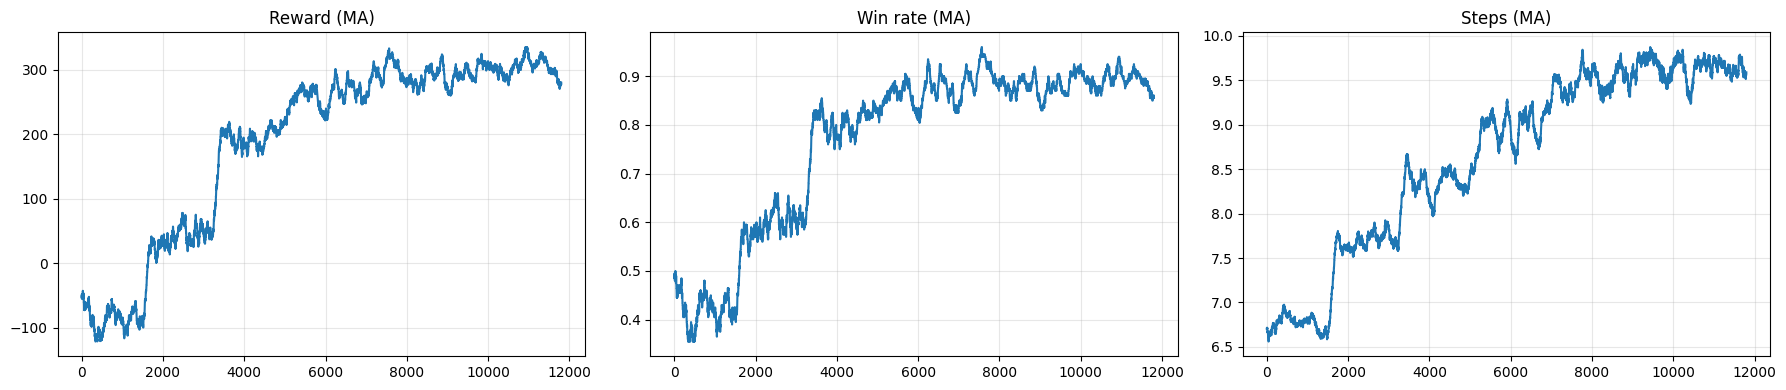

In [8]:


def main():
    random.seed(0); np.random.seed(0)

    corpus = load_words(CORPUS_FILE)
    test   = load_words(TEST_FILE)
    print(f"Corpus: {len(corpus)} | Test: {len(test)}")

    sequences = [[CHAR2ID[c] for c in w] for w in corpus if w]
    hmm = TrueHMM(num_states=8, seed=42, smoothing=1e-3)
    hmm.fit(sequences, iters=12, verbose=True)
    hmm.save(os.path.join(OUT_DIR, "hmm.pkl"))

    heur = HeuristicModel(corpus)

    env = HangmanEnv(corpus, max_wrong=6)
    agent = SuperHybridAgent(
        hmm, heur,
        epsilon_start=0.20, epsilon_end=0.02, epsilon_decay=0.9995,
        alpha=0.20, gamma=0.95
    )
    agent.train(env, episodes=12000, curriculum=(4,6,8,10,12,15,20))
    agent.save(os.path.join(OUT_DIR, "rl_agent.pkl"))
    plot_training(agent, OUT_DIR)

    results = evaluate(agent, test, games=min(2000, len(test)), max_wrong=6)
    with open(os.path.join(OUT_DIR, "eval_results.json"), "w") as f:
        json.dump(results, f, indent=2)
    print("[OK] Finished.")

if __name__ == "__main__":
    main()
